In [42]:
import numpy as np
import os
import matplotlib.pyplot as plt

name = "test-27"

p = os.path.abspath(f"../doctors/{name}/")

w_in = np.load(os.path.join(p, "w_in.npy"))
w = np.load(os.path.join(p, "w.npy"))
w_out = np.load(os.path.join(p, "w_out.npy"))
neurons = np.load(os.path.join(p, "neurons.npy")).T

print("W_in", "max", "mean", "sd")
print(np.max(np.abs(w_in)), np.mean(w_in), np.std(w_in))

print("W", "max", "mean", "sd")
print(np.max(np.abs(w)), np.mean(w), np.std(w))

print("W_out", "max", "mean", "sd")
print(np.max(np.abs(w_out)), np.mean(w_out), np.std(w_out))

W_in max mean sd
0.3185371849274283 0.0014386486148155661 0.09203007192120796
W max mean sd
0.35330853393849826 0.0011814029110812567 0.09056286123248401
W_out max mean sd
3.006887084084771 0.029714864239796315 1.0406424507755796


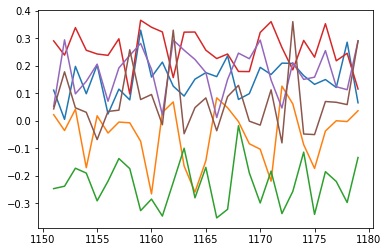

In [43]:
n = np.arange(neurons.shape[1])

indicies = n > 1150

plt.plot(n[indicies], neurons[0][indicies])
plt.plot(n[indicies], neurons[1][indicies])
plt.plot(n[indicies], neurons[2][indicies])
plt.plot(n[indicies], neurons[3][indicies])
plt.plot(n[indicies], neurons[4][indicies])
plt.plot(n[indicies], neurons[5][indicies])
